## SkimLit Project

> `The purpose is to build an NLP model which makes reading of medical abstracts easier`

> The paper we are replicating or from where we are getting the dataset is from: https://arxiv.org/abs/1710.06071

> From the above paper, we can see that the `model architecture` they have implemented to achive the best results is from: https://arxiv.org/pdf/1612.05251.pdf

> The dartaset we will be using is from the above paper(`PubMed 200k RCT`)

> The dataset is freely available on `Github`: https://github.com/Franck-Dernoncourt/pubmed-rct

## Getting the data

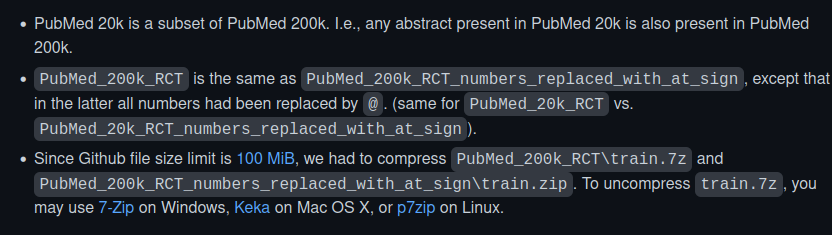

## Helper Function

In [1]:
!wget https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py

--2022-08-28 07:14:20--  https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19296 (19K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  18.84K  --.-KB/s    in 0.001s  

2022-08-28 07:14:20 (26.9 MB/s) - ‘helper_functions.py’ saved [19296/19296]



In [2]:
from helper_functions import unzip_data, plot_loss_curves, make_confusion_matrix, calculate_results, create_tensorboard_callback

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.


In [4]:
!ls /content/pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


## Using the `PubMed 20K RCT with number replaced with "@" sign`

In [5]:
data_dir='/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
data_dir

'/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

### Filenames in the directory

In [6]:
import os
filenames= [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [7]:
os.listdir(data_dir)

['dev.txt', 'train.txt', 'test.txt']

In [8]:
filenames[0]

'/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt'

## Preprocessing data

> Function to read in all of the lines of a target text file. 

In [9]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

### Reading the `training dataset` lines

In [10]:
train_lines=get_lines(filenames[0])
len(train_lines), train_lines[:30]

(35212,
 ['###24290286\n',
  'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
  'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
  'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
  'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
  'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
  'RESULTS\tSixty-five patients we

### Preprocessing Function

#### Example

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]
```

In [11]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
      # print(abstract_line_split)

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [12]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)


CPU times: user 700 ms, sys: 113 ms, total: 814 ms
Wall time: 901 ms


(180040, 30212, 30135)

In [13]:
train_samples[:20]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

## Visualizing the dataset

In [14]:
import pandas as pd
import numpy as np

In [260]:
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df= pd.DataFrame(test_samples)

In [16]:
train_df[:25]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


### Target Distribution

In [17]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

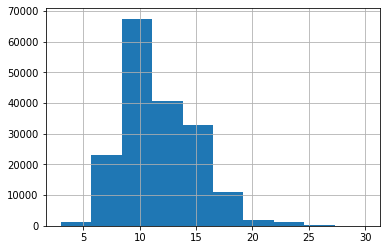

In [18]:
train_df['total_lines'].hist()

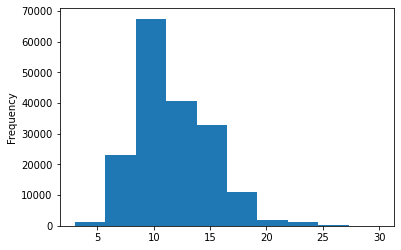

In [19]:
train_df['total_lines'].plot.hist()

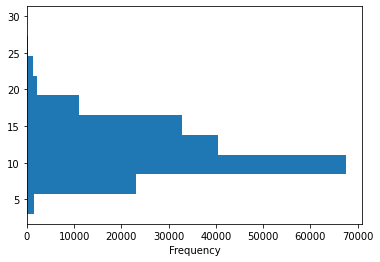

In [20]:
train_df['total_lines'].plot.hist(orientation='horizontal')

In [21]:
train_df['total_lines'].mean()

11.789135747611642

In [22]:
train_df['total_lines'].median()

11.0

In [23]:
train_sentences= train_df['text'].tolist()
val_sentences= val_df['text'].tolist()
test_sentences= test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [24]:
train_sentences[:11]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making numerical labels

> Machine Learning model require numerical labels

In [25]:
import sklearn
print(sklearn.__version__)

1.0.2


### One Hot Encoded labels

In [26]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder= OneHotEncoder(sparse=False)  # We want a non-sparse matrix. Tensorflow or tensor is not compatiable with sparse matrix
train_labels_one_hot= one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot= one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot= one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

In [27]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [28]:
train_labels_one_hot.shape

(180040, 5)

### Label encode `The target labels` 

> Extract labels `target columns` and encode them into integers. Encoding the `string/text` into `numbers`

In [29]:
from sklearn.preprocessing import LabelEncoder

label_encoder= LabelEncoder()
train_labels_encoder= label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoder= label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoder= label_encoder.transform(test_df['target'].to_numpy())

In [30]:
train_labels_encoder

array([3, 2, 2, ..., 4, 1, 1])

## Getting the class Names

In [31]:
num_classes= len(label_encoder.classes_)
class_names= label_encoder.classes_

class_names, num_classes

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object), 5)

## Model 0: Baseline Model

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [33]:
model_0= Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(train_sentences,train_labels_encoder)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

### Evaluating the model

In [34]:
baseline_score= model_0.score(val_sentences, val_labels_encoder)
baseline_score

0.7218323844829869

### Making Predictions

In [35]:
baseline_preds= model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Baseline Results

In [36]:
baseline_results=calculate_results(val_labels_encoder, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Text Vectorization

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [38]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

26

### Checking the length of the sentences

In [39]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len 

26.338269273494777

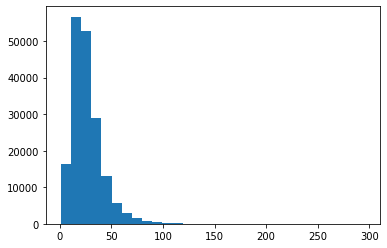

In [40]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=30);

### Checking which length covers about 95% of the sentences

In [41]:
output_sequence_length= int(np.percentile(sent_lens, 95))
output_sequence_length

55

In [42]:
min(sent_lens), max(sent_lens)

(1, 296)

In [43]:
max_length=round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
max_length

26

## Conclusion

> `26` would have been fine but `55` covers all `95%` of the sentences in the training data. So setting `output_sequence_length` to `55` would be better than `26`. 

In [44]:
max_vocab_length= 68000 # Taken from `Table 2` of the paper
max_length=output_sequence_length

text_vectorizer= TextVectorization(
    max_tokens= max_vocab_length, 
    output_sequence_length=max_length,
)

In [45]:
text_vectorizer

In [46]:
text_vectorizer.adapt(train_sentences)

In [47]:
sample_text="I am currently learning about Natural Language Processing in Machine Learning."
text_vectorizer([sample_text])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[ 389, 2651, 1325,  953,  338, 2266, 2111, 2573,    5, 9386,  953,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

### Words in the vocabulary

In [48]:
text_vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'and',
 'of',
 'in',
 'to',
 'with',
 'a',
 'were',
 'was',
 'for',
 'patients',
 'group',
 'p',
 'at',
 'or',
 'study',
 'on',
 'treatment',
 'is',
 'after',
 'by',
 'this',
 'groups',
 'as',
 'an',
 'from',
 'that',
 'randomized',
 'between',
 'not',
 'trial',
 'no',
 'compared',
 'control',
 'be',
 'significant',
 'intervention',
 'significantly',
 'n',
 'months',
 'than',
 'we',
 'vs',
 'rsb',
 'lsb',
 'clinical',
 'placebo',
 'baseline',
 'ci',
 'two',
 'during',
 'weeks',
 'both',
 'had',
 'primary',
 'mean',
 'are',
 'using',
 'participants',
 'there',
 'all',
 'time',
 'years',
 'pain',
 'therapy',
 'who',
 'mg',
 'more',
 'effect',
 'effects',
 'but',
 'risk',
 'difference',
 'outcomes',
 'total',
 'care',
 'rate',
 'efficacy',
 'received',
 'associated',
 'higher',
 'respectively',
 'days',
 'analysis',
 'outcome',
 'use',
 'one',
 'week',
 'women',
 'may',
 'randomly',
 'levels',
 'followup',
 'will',
 'increased',
 'health',
 'used',
 'have',
 'data'

### Length of the Vocabulary

In [49]:
rct_20k_text_vocab_len=len(text_vectorizer.get_vocabulary())
rct_20k_text_vocab_len

64841

### Most Common Words

In [50]:
text_vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'and', 'of']

### Least Common words

In [51]:
text_vectorizer.get_vocabulary()[-5:]

['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']

## Found some inconsistency in `text_vectorizer.get_config()` 

### From Video

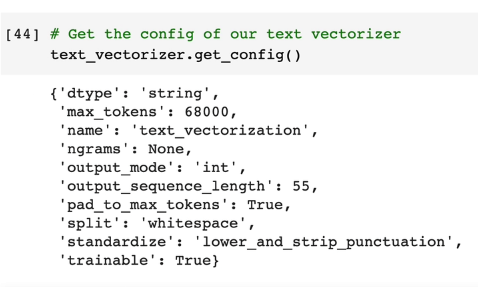


### From My Notebook
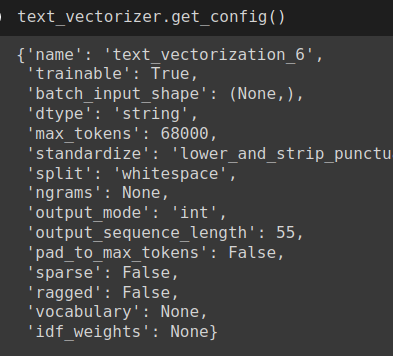

### Configuration of the Text Vectorizer 

In [52]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

## Embedding Layer

In [53]:
max_vocab_length

68000

In [54]:
rct_20k_text_vocab_len

64841

In [55]:
max_length

55

In [56]:
from tensorflow.keras import layers

embedding= layers.Embedding(input_dim=rct_20k_text_vocab_len, output_dim=128, mask_zero=True , name="token_embedding")

In [57]:
embedding

### Embedding Example

In [58]:
# Show example embedding
print(f"Sentence before vectorization:\n{sample_text}\n")
vectorized_sentence = text_vectorizer([sample_text])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = embedding(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
I am currently learning about Natural Language Processing in Machine Learning.

Sentence after vectorization (before embedding):
[[ 389 2651 1325  953  338 2266 2111 2573    5 9386  953    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.04351076  0.03811536 -0.04259342 ...  0.03274833 -0.04943013
   -0.0420863 ]
  [ 0.03373449  0.0150439  -0.00802218 ...  0.00765819  0.00130944
    0.02389686]
  [ 0.00623782  0.02091969 -0.0052285  ...  0.03656775 -0.02357739
    0.03912909]
  ...
  [-0.04877268 -0.01460943  0.02208897 ... -0.02441227  0.02971376
   -0.0008278 ]
  [-0.04877268 -0.01460943  0.02208897 ... -0.02441227  0.02971376
   -0.0008278 ]
  [-0.04877268 -0.01460943  0.02208897 ... -0.02441227  0.02971376
   -0.0008278 ]]]

Embedded sentence sha

## Making Datasets load as fast as possible

In [59]:
train_dataset= tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset= tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset= tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [60]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [61]:
train_labels_one_hot.shape

(180040, 5)

In [62]:
train_labels_one_hot[0]

array([0., 0., 0., 1., 0.])

### Turning the dataset into prefetched datasets

> We are not shuffeling the `training dataset` as we are building a model for `seq2seq` or `sequence2sequence` problems where the sequences matter.

In [63]:
train_dataset= train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset= val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset= test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [64]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [65]:
num_classes

5

In [66]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [67]:
inputs= layers.Input(shape=(1,), dtype="string")
x= text_vectorizer(inputs)
x=embedding(x)
x=layers.Conv1D(64, 5, padding="same", activation="relu")(x)
x=layers.GlobalAveragePooling1D(name="global_average_pooling1D")(x)
x=layers.Dense(64, activation="relu")(x)
outputs= layers.Dense(num_classes, activation="softmax", name="output_layer")(x)
model_1= tf.keras.Model(inputs, outputs, name="conv1D_with_token_embeddings")


In [68]:
model_1.summary()

Model: "conv1D_with_token_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1D (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64

In [69]:
SAVE_DIR="model_logs"

In [70]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [71]:
len(train_dataset)

5627

In [72]:
len(train_dataset) * 32

180064

In [73]:
int(0.1 * len(train_dataset))

562

In [74]:
model_1.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_1= model_1.fit(train_dataset, steps_per_epoch=int(0.1 * len(train_dataset)) ,epochs=5, validation_data=val_dataset, validation_steps=int(0.1 * len(val_dataset)) ,callbacks=[create_tensorboard_callback(SAVE_DIR, "model_1_Conv1D_token_embeddings")])

Saving TensorBoard log files to: model_logs/model_1_Conv1D_token_embeddings/20220828-071524
Epoch 1/5
562/562 [==============================] - 17s 9ms/step - loss: 0.8969 - accuracy: 0.6317 - val_loss: 0.6673 - val_accuracy: 0.7400
Epoch 2/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6519 - accuracy: 0.7500 - val_loss: 0.6274 - val_accuracy: 0.7593
Epoch 3/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6094 - accuracy: 0.7721 - val_loss: 0.5702 - val_accuracy: 0.7889
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5757 - accuracy: 0.7884 - val_loss: 0.5504 - val_accuracy: 0.7912
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5741 - accuracy: 0.7894 - val_loss: 0.5330 - val_accuracy: 0.8019


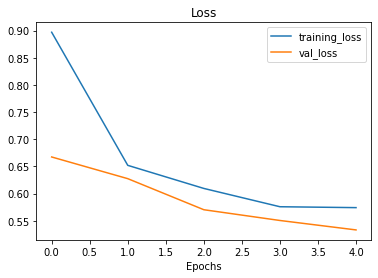

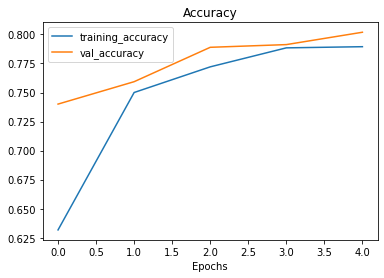

In [75]:
plot_loss_curves(history_1)

### Evaluating the model

In [76]:
model_1_evaluate= model_1.evaluate(val_dataset)
model_1_evaluate

945/945 [==============================] - 5s 5ms/step - loss: 0.5408 - accuracy: 0.8015


[0.5408113598823547, 0.8015357851982117]

In [77]:
model_1_pred_probs= model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[6.20186865e-01, 1.18802905e-01, 2.46915370e-02, 2.08289191e-01,
         2.80295406e-02],
        [4.73628461e-01, 3.47261965e-01, 6.44870382e-03, 1.56570643e-01,
         1.60902292e-02],
        [2.01025337e-01, 6.59455778e-03, 1.17344232e-02, 7.80362070e-01,
         2.83644884e-04],
        ...,
        [6.35806937e-05, 1.19542761e-03, 5.46566024e-03, 7.85441352e-06,
         9.93267536e-01],
        [1.02200381e-01, 3.56606901e-01, 1.05397061e-01, 7.51592591e-02,
         3.60636413e-01],
        [6.49143457e-02, 8.77292633e-01, 1.27473734e-02, 1.05998842e-02,
         3.44457850e-02]], dtype=float32), (30212, 5))

In [78]:
model_1_preds= tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [79]:
model_1_results= calculate_results(val_labels_encoder,model_1_preds)
model_1_results

{'accuracy': 80.15358135840064,
 'precision': 0.8003315270716257,
 'recall': 0.8015358135840064,
 'f1': 0.7996846214912741}

In [80]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Tensorflow Hub Pre-trained Feature Extractor

> Model Link(`USE`) -> https://tfhub.dev/google/universal-sentence-encoder/4

In [81]:
model_url='https://tfhub.dev/google/universal-sentence-encoder/4'

In [82]:
import tensorflow_hub as hub

### Sentence Encoder Layer

In [83]:
sentence_encoder_layer= hub.KerasLayer(model_url, input_shape=[], dtype="string", trainable=False, name="transfer_learning_USE")

In [84]:
model_2= tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(num_classes, activation="softmax")
], name="USE_feature_extractor")

In [85]:
model_2.summary()

Model: "USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transfer_learning_USE (Kera  (None, 512)              256797824 
 sLayer)                                                         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 256,800,389
Trainable params: 2,565
Non-trainable params: 256,797,824
_________________________________________________________________


In [86]:
model_2.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_2= model_2.fit(train_dataset, epochs=5, steps_per_epoch=int(0.1 * len(train_dataset)), validation_data= val_dataset, validation_steps= int(0.1 * len(val_dataset)), callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_USE_feature_extractor")])

Saving TensorBoard log files to: model_logs/model_2_USE_feature_extractor/20220828-071628
Epoch 1/5
562/562 [==============================] - 10s 13ms/step - loss: 1.2578 - accuracy: 0.5481 - val_loss: 1.0853 - val_accuracy: 0.6024
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 1.0117 - accuracy: 0.6254 - val_loss: 0.9556 - val_accuracy: 0.6533
Epoch 3/5
562/562 [==============================] - 7s 13ms/step - loss: 0.9309 - accuracy: 0.6551 - val_loss: 0.8958 - val_accuracy: 0.6732
Epoch 4/5
562/562 [==============================] - 7s 13ms/step - loss: 0.8740 - accuracy: 0.6795 - val_loss: 0.8626 - val_accuracy: 0.6759
Epoch 5/5
562/562 [==============================] - 7s 13ms/step - loss: 0.8631 - accuracy: 0.6767 - val_loss: 0.8411 - val_accuracy: 0.6838


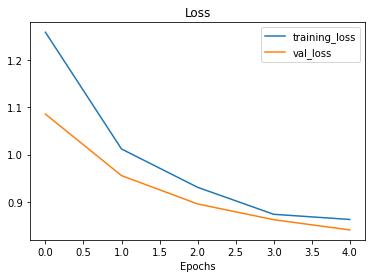

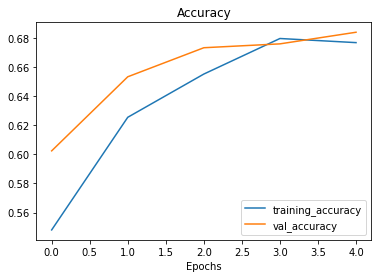

In [87]:
plot_loss_curves(history_2)

In [88]:
model_2_evaluate=model_2.evaluate(val_dataset)
model_2_evaluate

945/945 [==============================] - 10s 11ms/step - loss: 0.8389 - accuracy: 0.6878


[0.8389446139335632, 0.6878061890602112]

In [89]:
model_2_pred_probs= model_2.predict(val_dataset)
model_2_pred_probs

array([[0.46562997, 0.32207978, 0.02584916, 0.13574478, 0.05069628],
       [0.3793285 , 0.47169602, 0.01865368, 0.09420102, 0.03612084],
       [0.24458745, 0.2598681 , 0.07557989, 0.30116686, 0.1187977 ],
       ...,
       [0.010851  , 0.00985326, 0.15340313, 0.00644032, 0.8194522 ],
       [0.02540837, 0.06001698, 0.3535176 , 0.01052814, 0.5505289 ],
       [0.22382763, 0.10323156, 0.49190262, 0.01959813, 0.16143997]],
      dtype=float32)

In [90]:
model_2_preds= tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [91]:
model_2_results= calculate_results(val_labels_encoder, model_2_preds)
model_2_results

{'accuracy': 68.78061697338805,
 'precision': 0.6792102363753849,
 'recall': 0.6878061697338805,
 'f1': 0.6784719323904964}

In [92]:
model_1_results

{'accuracy': 80.15358135840064,
 'precision': 0.8003315270716257,
 'recall': 0.8015358135840064,
 'f1': 0.7996846214912741}

In [93]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2_1: Tensorflow Hub Pre-trained Feature Extractor

> Model Link(`USE`) -> https://tfhub.dev/google/universal-sentence-encoder/4

In [94]:
tf_hub_embedding_layer = hub.KerasLayer(model_url,trainable=False, name="universal_sentence_encoder")

In [95]:
inputs= layers.Input(shape=[], dtype="string")
pretrained_embedding= tf_hub_embedding_layer(inputs)
x= layers.Dense(128, activation="relu")(pretrained_embedding)
outputs= layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

model_2_1= tf.keras.Model(inputs, outputs, name="USE_feature_extraction_with_sequential_API")

model_2_1.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam())

In [96]:
model_2_1.summary()

Model: "USE_feature_extraction_with_sequential_API"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [97]:
history_2_1= model_2_1.fit(train_dataset, epochs=5, steps_per_epoch=int(0.1 * len(train_dataset)), validation_data= val_dataset, validation_steps= int(0.1 * len(val_dataset)), callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_1_USE_feature_extractor")])

Saving TensorBoard log files to: model_logs/model_2_1_USE_feature_extractor/20220828-071732
Epoch 1/5
562/562 [==============================] - 10s 14ms/step - loss: 0.9170 - accuracy: 0.6506 - val_loss: 0.7984 - val_accuracy: 0.6878
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7692 - accuracy: 0.7009 - val_loss: 0.7562 - val_accuracy: 0.7058
Epoch 3/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7536 - accuracy: 0.7122 - val_loss: 0.7401 - val_accuracy: 0.7098
Epoch 4/5
562/562 [==============================] - 9s 15ms/step - loss: 0.7195 - accuracy: 0.7251 - val_loss: 0.7125 - val_accuracy: 0.7291
Epoch 5/5
562/562 [==============================] - 8s 13ms/step - loss: 0.7273 - accuracy: 0.7205 - val_loss: 0.6911 - val_accuracy: 0.7311


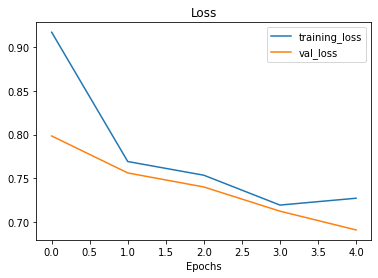

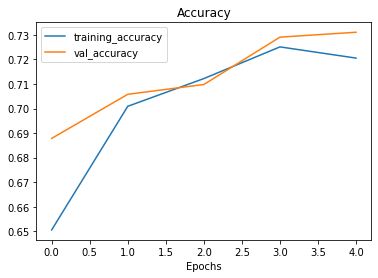

In [98]:
plot_loss_curves(history_2_1)

In [99]:
model_2_1_evaluate=model_2_1.evaluate(val_dataset)
model_2_1_evaluate

945/945 [==============================] - 10s 11ms/step - loss: 0.6991 - accuracy: 0.7335


[0.69910728931427, 0.7334502935409546]

In [100]:
model_2_1_pred_probs= model_2_1.predict(val_dataset)
model_2_1_pred_probs

array([[6.6034532e-01, 2.1988149e-01, 2.7585996e-03, 1.0698673e-01,
        1.0027856e-02],
       [4.0359828e-01, 4.9595016e-01, 4.4169319e-03, 9.3503498e-02,
        2.5311094e-03],
       [4.0931079e-01, 6.0789622e-02, 4.1580249e-02, 4.5110524e-01,
        3.7214160e-02],
       ...,
       [1.7813490e-03, 2.4696956e-03, 1.2428522e-01, 8.3399302e-04,
        8.7062973e-01],
       [2.5815545e-03, 2.4868153e-02, 4.8571986e-01, 1.0461690e-03,
        4.8578426e-01],
       [1.5557392e-01, 3.3155170e-01, 4.5650387e-01, 3.3624228e-03,
        5.3008221e-02]], dtype=float32)

In [101]:
model_2_1_preds= tf.argmax(model_2_1_pred_probs, axis=1)
model_2_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [102]:
model_2_1_results= calculate_results(val_labels_encoder, model_2_1_preds)
model_2_1_results

{'accuracy': 73.3450284655104,
 'precision': 0.729876928343822,
 'recall': 0.733450284655104,
 'f1': 0.7275679503273829}

In [103]:
model_1_results

{'accuracy': 80.15358135840064,
 'precision': 0.8003315270716257,
 'recall': 0.8015358135840064,
 'f1': 0.7996846214912741}

In [104]:
model_2_results

{'accuracy': 68.78061697338805,
 'precision': 0.6792102363753849,
 'recall': 0.6878061697338805,
 'f1': 0.6784719323904964}

In [105]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 3: Conv1D with Character Level Embeddings

In [106]:
list(sample_text)

['I',
 ' ',
 'a',
 'm',
 ' ',
 'c',
 'u',
 'r',
 'r',
 'e',
 'n',
 't',
 'l',
 'y',
 ' ',
 'l',
 'e',
 'a',
 'r',
 'n',
 'i',
 'n',
 'g',
 ' ',
 'a',
 'b',
 'o',
 'u',
 't',
 ' ',
 'N',
 'a',
 't',
 'u',
 'r',
 'a',
 'l',
 ' ',
 'L',
 'a',
 'n',
 'g',
 'u',
 'a',
 'g',
 'e',
 ' ',
 'P',
 'r',
 'o',
 'c',
 'e',
 's',
 's',
 'i',
 'n',
 'g',
 ' ',
 'i',
 'n',
 ' ',
 'M',
 'a',
 'c',
 'h',
 'i',
 'n',
 'e',
 ' ',
 'L',
 'e',
 'a',
 'r',
 'n',
 'i',
 'n',
 'g',
 '.']

In [107]:
" ".join(list(sample_text))

'I   a m   c u r r e n t l y   l e a r n i n g   a b o u t   N a t u r a l   L a n g u a g e   P r o c e s s i n g   i n   M a c h i n e   L e a r n i n g .'

### Function to split sentences into characters

In [108]:
def split_sentences(text):
  """
    Function to split text/sentences into characters

  """

  return " ".join(list(text))

In [109]:
split_sentences(sample_text)

'I   a m   c u r r e n t l y   l e a r n i n g   a b o u t   N a t u r a l   L a n g u a g e   P r o c e s s i n g   i n   M a c h i n e   L e a r n i n g .'

### Character Datasets

In [110]:
train_characters= [split_sentences(sent) for sent in train_sentences]
val_characters= [split_sentences(sent) for sent in val_sentences]
test_characters= [split_sentences(sent) for sent in test_sentences]
train_characters[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 


### Average Character Length

In [111]:
char_lens= [len(sentence) for sentence in train_sentences]
mean_char_len= np.mean(char_lens)
mean_char_len

149.3662574983337

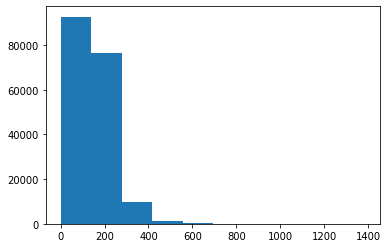

In [112]:
plt.hist(char_lens);

In [113]:
output_seq_char_len=int(np.percentile(char_lens, 95))
output_seq_char_len

290

### Get all keyword characters(Alphanumeric characters)

In [114]:
import string
alphabet= string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [115]:
len(alphabet)

68

### Creating Character Level Token Vectorizer instance

In [116]:
NUM_CHAR_TOKENS= (len(alphabet) + 2) # For "whitespace" and "OOV" token (OOV= Out of Vocabulary, '[UNK])
char_vectorizer= TextVectorization(max_tokens= NUM_CHAR_TOKENS, output_sequence_length= output_seq_char_len, name="char_vectorizer")
char_vectorizer.adapt(train_characters)
char_vectorizer

### Check character vocabulary characteristics

In [117]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")


Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


### Test out character vectorizer

In [118]:
import random

In [119]:
random_train_chars = random.choice(train_characters)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
n o   o t h e r   b e t w e e n - g r o u p   d i f f e r e n c e s   w e r e   o b s e r v e d   f o r   a n y   c a r d i o v a s c u l a r   r i s k   f a c t o r   ,   h e a l t h   b e h a v i o u r   o r   p a t i e n t - r e p o r t e d   o u t c o m e   v a r i a b l e s   .

Length of chars: 124

Vectorized chars:
[[ 6  7  7  3 13  2  8 22  2  3 20  2  2  6 18  8  7 16 14 10  4 17 17  2
   8  2  6 11  2  9 20  2  8  2  7 22  9  2  8 21  2 10 17  7  8  5  6 19
  11  5  8 10  4  7 21  5  9 11 16 12  5  8  8  4  9 23 17  5 11  3  7  8
  13  2  5 12  3 13 22  2 13  5 21  4  7 16  8  7  8 14  5  3  4  2  6  3
   8  2 14  7  8  3  2 10  7 16  3 11  7 15  2 21  5  8  4  5 22 12  2  9
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

## Character Level Embeddings

In [120]:
char_embedding= layers.Embedding(input_dim= len(char_vocab), output_dim=25, mask_zero=True, name="char_embed") # output_dim=25, got it from the paper, Figure 1

### Test out character embedding layer

In [121]:
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embedding(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
n o   o t h e r   b e t w e e n - g r o u p   d i f f e r e n c e s   w e r e   o b s e r v e d   f o r   a n y   c a r d i o v a s c u l a r   r i s k   f a c t o r   ,   h e a l t h   b e h a v i o u r   o r   p a t i e n t - r e p o r t e d   o u t c o m e   v a r i a b l e s   .

Embedded chars (after vectorization and embedding):
[[[ 0.03551005 -0.03436136 -0.02075613 ...  0.03440625  0.04719902
   -0.00179356]
  [-0.03993889  0.03226712 -0.04208996 ... -0.04390943  0.04553663
   -0.01468014]
  [-0.03993889  0.03226712 -0.04208996 ... -0.04390943  0.04553663
   -0.01468014]
  ...
  [-0.04524461 -0.00512631  0.00850457 ...  0.02753309  0.04586741
    0.03936822]
  [-0.04524461 -0.00512631  0.00850457 ...  0.02753309  0.04586741
    0.03936822]
  [-0.04524461 -0.00512631  0.00850457 ...  0.02753309  0.04586741
    0.03936822]]]

Character embedding shape: (1, 290, 25)


## Building a Conv1D model with Character Embeddings

In [122]:
inputs= layers.Input(shape=(1,), dtype="string")
x= char_vectorizer(inputs)
x=char_embedding(x)
x=layers.Conv1D(64, 5, padding="same", activation="relu")(x)
x=layers.GlobalAveragePooling1D(name="global_average_pooling1D")(x)
x=layers.Dense(64, activation="relu")(x)
outputs= layers.Dense(num_classes, activation="softmax", name="output_layer")(x)
model_3= tf.keras.Model(inputs, outputs, name="conv1D_with_character_embeddings")


In [123]:
model_3.summary()

Model: "conv1D_with_character_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1D (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_3 (Dense)             (None

## Making Character Datasets load as fast as possible

In [124]:
train_character_dataset= tf.data.Dataset.from_tensor_slices((train_characters, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_character_dataset= tf.data.Dataset.from_tensor_slices((val_characters, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_character_dataset= tf.data.Dataset.from_tensor_slices((test_characters, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [125]:
train_character_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [126]:
model_3.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_3= model_3.fit(train_character_dataset, steps_per_epoch=int(0.1 * len(train_character_dataset)) ,epochs=5, validation_data=val_character_dataset, validation_steps=int(0.1 * len(val_character_dataset)) ,callbacks=[create_tensorboard_callback(SAVE_DIR, "model_3_Conv1D_character_embeddings")])

Saving TensorBoard log files to: model_logs/model_3_Conv1D_character_embeddings/20220828-071852
Epoch 1/5
562/562 [==============================] - 4s 6ms/step - loss: 1.4471 - accuracy: 0.3537 - val_loss: 1.3803 - val_accuracy: 0.4009
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 1.3513 - accuracy: 0.4203 - val_loss: 1.3133 - val_accuracy: 0.4511
Epoch 3/5
562/562 [==============================] - 3s 6ms/step - loss: 1.3002 - accuracy: 0.4589 - val_loss: 1.2790 - val_accuracy: 0.4658
Epoch 4/5
562/562 [==============================] - 3s 6ms/step - loss: 1.2696 - accuracy: 0.4714 - val_loss: 1.2565 - val_accuracy: 0.4830
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 1.2585 - accuracy: 0.4756 - val_loss: 1.2370 - val_accuracy: 0.4993


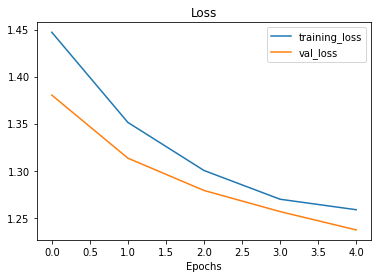

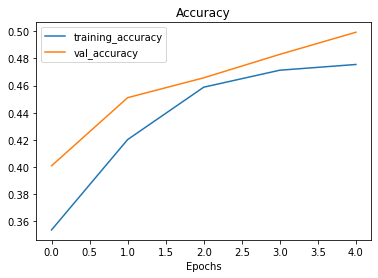

In [127]:
plot_loss_curves(history_3)

In [128]:
model_3_evaluate=model_3.evaluate(val_character_dataset)
model_3_evaluate

945/945 [==============================] - 3s 4ms/step - loss: 1.2409 - accuracy: 0.4952


[1.240902066230774, 0.49516749382019043]

In [129]:
model_3_pred_probs= model_3.predict(val_character_dataset)
model_3_pred_probs

array([[0.24207993, 0.22903997, 0.24069594, 0.21685989, 0.07132423],
       [0.12000344, 0.19489098, 0.18856367, 0.05090228, 0.4456396 ],
       [0.1442019 , 0.13966925, 0.4954961 , 0.14658159, 0.07405121],
       ...,
       [0.05859035, 0.1177013 , 0.22169866, 0.02928699, 0.5727227 ],
       [0.07314319, 0.14064334, 0.3083289 , 0.07129893, 0.40658566],
       [0.21288918, 0.18352066, 0.19992727, 0.03504151, 0.36862135]],
      dtype=float32)

In [130]:
model_3_preds= tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 4, 2, ..., 4, 4, 4])>

In [131]:
model_3_results= calculate_results(val_labels_encoder, model_3_preds)
model_3_results

{'accuracy': 49.516748311929035,
 'precision': 0.4663114765918066,
 'recall': 0.4951674831192904,
 'f1': 0.4586469706900689}

## Model 3_1: Building a Conv1D model with Character Embeddings

In [132]:
inputs= layers.Input(shape=(1,), dtype="string")
x= char_vectorizer(inputs)
x=char_embedding(x)
x=layers.Conv1D(64, 5, padding="same", activation="relu")(x)
x=layers.GlobalMaxPooling1D(name="global_max_pooling1D")(x)
x=layers.Dense(64, activation="relu")(x)
outputs= layers.Dense(num_classes, activation="softmax", name="output_layer")(x)
model_3_1= tf.keras.Model(inputs, outputs, name="conv1D_with_character_embeddings")

In [133]:
model_3_1.summary()

Model: "conv1D_with_character_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1D (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None

In [134]:
model_3_1.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_3_1= model_3_1.fit(train_character_dataset, steps_per_epoch=int(0.1 * len(train_character_dataset)) ,epochs=5, validation_data=val_character_dataset, validation_steps=int(0.1 * len(val_character_dataset)) ,callbacks=[create_tensorboard_callback(SAVE_DIR, "model_3_Conv1D_character_embeddings_with_max_pooling")])

Saving TensorBoard log files to: model_logs/model_3_Conv1D_character_embeddings_with_max_pooling/20220828-071919
Epoch 1/5
562/562 [==============================] - 4s 6ms/step - loss: 1.2257 - accuracy: 0.4827 - val_loss: 1.0774 - val_accuracy: 0.5316
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 1.0382 - accuracy: 0.5658 - val_loss: 0.9658 - val_accuracy: 0.6041
Epoch 3/5
562/562 [==============================] - 3s 6ms/step - loss: 0.9523 - accuracy: 0.6179 - val_loss: 0.8852 - val_accuracy: 0.6373
Epoch 4/5
562/562 [==============================] - 3s 6ms/step - loss: 0.8960 - accuracy: 0.6382 - val_loss: 0.8922 - val_accuracy: 0.6343
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 0.8778 - accuracy: 0.6499 - val_loss: 0.8619 - val_accuracy: 0.6629


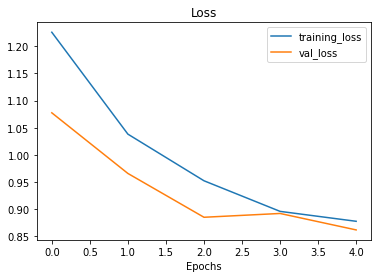

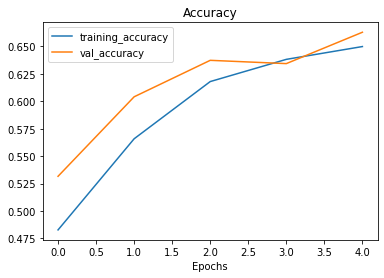

In [135]:
plot_loss_curves(history_3_1)

In [136]:
model_3_1_evaluate=model_3_1.evaluate(val_character_dataset)
model_3_1_evaluate

945/945 [==============================] - 4s 4ms/step - loss: 0.8708 - accuracy: 0.6627


[0.870811939239502, 0.6627498865127563]

In [137]:
model_3_1_pred_probs= model_3_1.predict(val_character_dataset)
model_3_1_pred_probs

array([[0.19385815, 0.46842074, 0.00891125, 0.30024886, 0.02856102],
       [0.24574094, 0.18174237, 0.0119652 , 0.55453914, 0.00601232],
       [0.22457032, 0.1718626 , 0.0133125 , 0.58413327, 0.00612128],
       ...,
       [0.03275351, 0.07352819, 0.06924815, 0.02299581, 0.80147433],
       [0.03662772, 0.16357866, 0.5432453 , 0.0583917 , 0.19815661],
       [0.5656634 , 0.23828271, 0.0910857 , 0.09648792, 0.00848032]],
      dtype=float32)

In [138]:
model_3_1_preds= tf.argmax(model_3_1_pred_probs, axis=1)
model_3_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 2, 0])>

In [139]:
model_3_1_results= calculate_results(val_labels_encoder, model_3_1_preds)
model_3_1_results

{'accuracy': 66.27499007017079,
 'precision': 0.6794439370228661,
 'recall': 0.6627499007017079,
 'f1': 0.6690440483559759}

In [140]:
model_3_results

{'accuracy': 49.516748311929035,
 'precision': 0.4663114765918066,
 'recall': 0.4951674831192904,
 'f1': 0.4586469706900689}

In [141]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [142]:
model_2_results

{'accuracy': 68.78061697338805,
 'precision': 0.6792102363753849,
 'recall': 0.6878061697338805,
 'f1': 0.6784719323904964}

## Model 4: Combining pretrained token embeddings + character embeddings(hybrid embedding layer)

### We Need:

1. Token Level Embedding model(similar to `model_1`)
2. Character Level Embedding( similar to `model_3` with a slight modification)
3. Combine the above steps, with a concatenate(`layers.concatenate`)
4. Build a series of output layers on top of `step 3`, similar to Figure 1 in section 4.2 of the paper
5. Construct a model which takes `token and character` `level sequences as inputs` and `produces sequence label probabilities as output`.


### `Step: 1` Setup token inputs/model

In [143]:
token_inputs= layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings= tf_hub_embedding_layer(token_inputs)
token_output= layers.Dense(128, activation="relu")(token_embeddings)
token_model= tf.keras.Model(token_inputs, token_output, name="token_embedding_output")

### `Step: 2` Setup character inputs/model

In [144]:
character_inputs= layers.Input(shape=(1,), dtype="string", name="character_inputs")
character_vectors= char_vectorizer(character_inputs)
character_embeddings= char_embedding(character_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(25))(character_embeddings) # Bi-LSTM as shown in Figure 1 of the paper
character_model= tf.keras.Model(character_inputs, char_bi_lstm, name="character_embedding_output")

### `Step: 3` Concatenate `the token and character embedding model outputs` as `inputs`(Create hybrid token embedding)

In [145]:
token_char_concat= layers.Concatenate(name="token_character_hybrid")([token_model.output, character_model.output])

### `Step : 4` Create output layers, in addition add `Dropout` layers as discussed in Section 4.2 of the paper

In [146]:
combined_dropout= layers.Dropout(0.5)(token_char_concat)
combined_dense= layers.Dense(200, activation="relu")(combined_dropout)
final_dropout= layers.Dropout(0.5)(combined_dense)
combined_output= layers.Dense(num_classes, activation="softmax", name="combined_output")(final_dropout)

### `Step: 5` Build a model with token and character inputs

In [147]:
model_4= tf.keras.Model(inputs= [token_model.input, character_model.input], outputs= combined_output, name="model_4_token_and_character_embeddings")

In [148]:
model_4.summary()

Model: "model_4_token_and_character_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 character_inputs (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['character_inputs[0][0]']       
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         25679782

## Visualize `model_4`

In [149]:
from tensorflow.keras.utils import plot_model

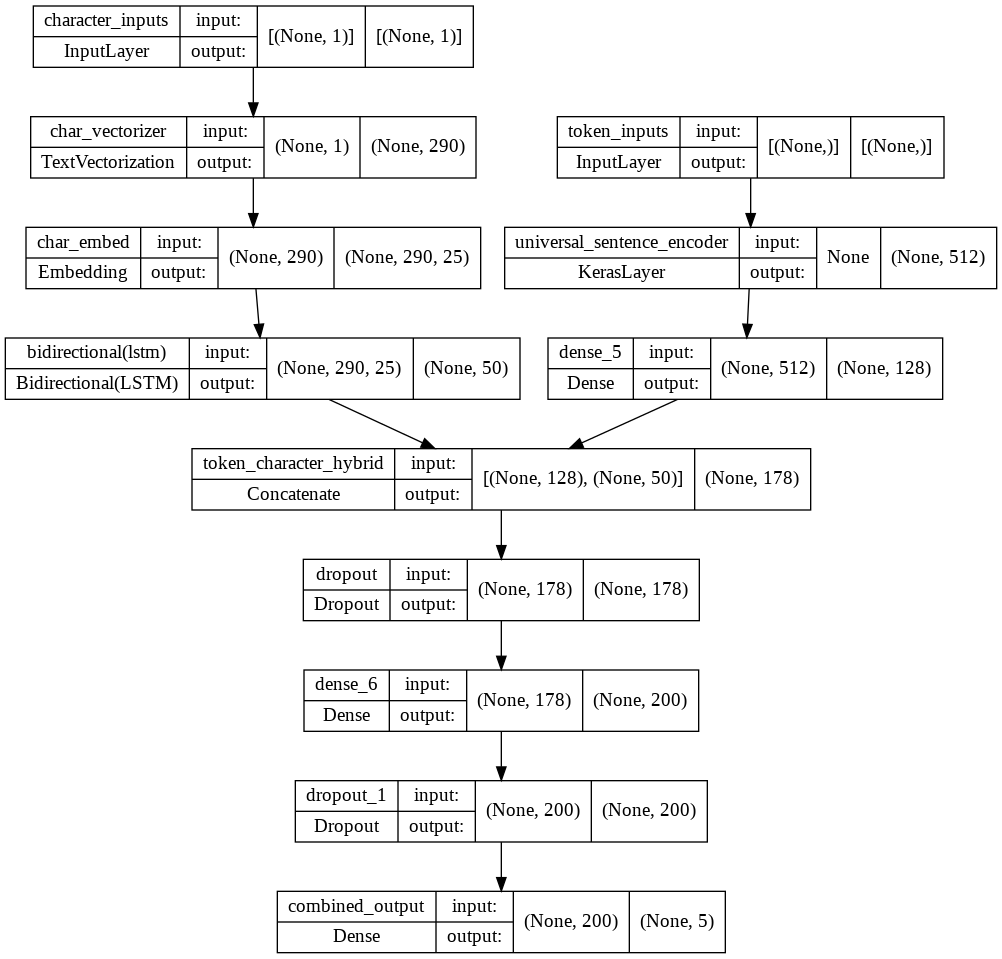

In [150]:
plot_model(model_4, show_shapes=True)

In [151]:
model_4.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer= tf.keras.optimizers.Adam())

## Combining token and character data into datasets for faster loading

In [152]:
train_char_token_data= tf.data.Dataset.from_tensor_slices((train_sentences, train_characters)) # Data
train_char_token_labels= tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # Labels
train_char_token_dataset= tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # Combining data and labels

In [153]:
train_char_token_dataset= train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [154]:
val_char_token_data= tf.data.Dataset.from_tensor_slices((val_sentences, val_characters)) # Data
val_char_token_labels= tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # Labels
val_char_token_dataset= tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # Combining data and labels

val_char_token_dataset= val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [155]:
test_char_token_data= tf.data.Dataset.from_tensor_slices((test_sentences, test_characters)) # Data
test_char_token_labels= tf.data.Dataset.from_tensor_slices(test_labels_one_hot) # Labels
test_char_token_dataset= tf.data.Dataset.zip((test_char_token_data, test_char_token_labels)) # Combining data and labels

test_char_token_dataset= test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [156]:
train_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [157]:
history_4= model_4.fit(train_char_token_dataset, epochs=5, steps_per_epoch=int(0.1 * len(train_char_token_dataset)), validation_data=val_char_token_dataset, validation_steps=int(0.1 * len(val_char_token_dataset)), callbacks=[create_tensorboard_callback(SAVE_DIR, "model_4_token_and_character_embedding_hybrid_model")])

Saving TensorBoard log files to: model_logs/model_4_token_and_character_embedding_hybrid_model/20220828-071951
Epoch 1/5
562/562 [==============================] - 42s 58ms/step - loss: 0.9639 - accuracy: 0.6148 - val_loss: 0.7641 - val_accuracy: 0.7084
Epoch 2/5
562/562 [==============================] - 31s 54ms/step - loss: 0.7845 - accuracy: 0.6983 - val_loss: 0.7012 - val_accuracy: 0.7337
Epoch 3/5
562/562 [==============================] - 29s 51ms/step - loss: 0.7643 - accuracy: 0.7060 - val_loss: 0.6840 - val_accuracy: 0.7407
Epoch 4/5
562/562 [==============================] - 31s 55ms/step - loss: 0.7306 - accuracy: 0.7237 - val_loss: 0.6605 - val_accuracy: 0.7470
Epoch 5/5
562/562 [==============================] - 27s 49ms/step - loss: 0.7420 - accuracy: 0.7187 - val_loss: 0.6593 - val_accuracy: 0.7463


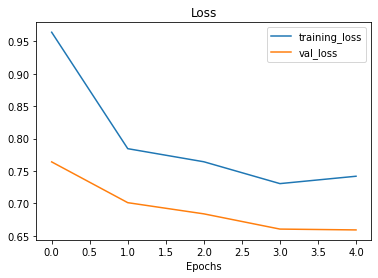

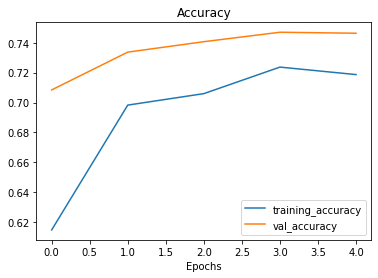

In [158]:
plot_loss_curves(history_4)

In [159]:
model_4_evaluate=model_4.evaluate(val_char_token_dataset)
model_4_evaluate

945/945 [==============================] - 24s 25ms/step - loss: 0.6649 - accuracy: 0.7463


[0.664914608001709, 0.7462928891181946]

In [160]:
model_4_pred_probs= model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[5.6964040e-01, 2.3277429e-01, 5.0741844e-03, 1.8291880e-01,
        9.5923385e-03],
       [4.3934417e-01, 4.4186252e-01, 9.1937128e-03, 1.0450972e-01,
        5.0898506e-03],
       [3.5140255e-01, 7.7769816e-02, 1.2930083e-01, 3.8569161e-01,
        5.5835221e-02],
       ...,
       [2.6639889e-04, 2.4469229e-03, 2.8155142e-02, 8.0738209e-05,
        9.6905082e-01],
       [8.9671249e-03, 3.4148369e-02, 4.1622192e-01, 4.9153180e-03,
        5.3574729e-01],
       [3.1926146e-01, 4.7626966e-01, 1.6504276e-01, 9.9122347e-03,
        2.9513905e-02]], dtype=float32)

In [161]:
model_4_preds= tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [162]:
model_4_results= calculate_results(val_labels_encoder, model_4_preds)
model_4_results

{'accuracy': 74.62928637627432,
 'precision': 0.745298880216739,
 'recall': 0.7462928637627433,
 'f1': 0.7396995279441884}

In [163]:
model_3_1_results

{'accuracy': 66.27499007017079,
 'precision': 0.6794439370228661,
 'recall': 0.6627499007017079,
 'f1': 0.6690440483559759}

In [164]:
model_3_results

{'accuracy': 49.516748311929035,
 'precision': 0.4663114765918066,
 'recall': 0.4951674831192904,
 'f1': 0.4586469706900689}

In [165]:
model_2_results

{'accuracy': 68.78061697338805,
 'precision': 0.6792102363753849,
 'recall': 0.6878061697338805,
 'f1': 0.6784719323904964}

In [166]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [167]:
model_1_results

{'accuracy': 80.15358135840064,
 'precision': 0.8003315270716257,
 'recall': 0.8015358135840064,
 'f1': 0.7996846214912741}

## `Model: 5` Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings


## Feature Engineering

> Any Engineered features used to train a model need to be available at test time. In this case, `line numbers and total lines` are available

In [168]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Line Number Feature

In [169]:
train_df["line_number"]

0          0
1          1
2          2
3          3
4          4
          ..
180035     7
180036     8
180037     9
180038    10
180039    11
Name: line_number, Length: 180040, dtype: int64

### Create Positional Embeddings

In [170]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

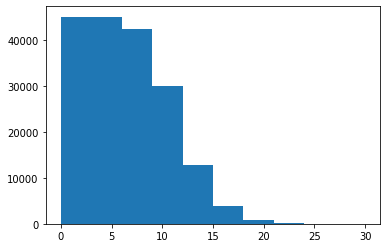

In [171]:
plt.hist(train_df["line_number"]);

In [172]:
np.percentile(train_df["line_number"], 95)

13.0

In [173]:
train_df_line_numbers= train_df["line_number"].to_numpy()
val_df_line_numbers= val_df["line_number"].to_numpy()
test_df_line_numbers= test_df["line_number"].to_numpy()

train_df_line_numbers, train_df_line_numbers.shape

(array([ 0,  1,  2, ...,  9, 10, 11]), (180040,))

### One-Hot Encoding the `Line Numbers` of the datasets

In [174]:
train_line_numbers_one_hot= tf.one_hot(train_df_line_numbers, depth=15)
val_line_numbers_one_hot= tf.one_hot(val_df_line_numbers, depth=15)
test_line_numbers_one_hot= tf.one_hot(test_df_line_numbers, depth=15)

train_line_numbers_one_hot, train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 15]))

### Total Lines Feature

In [175]:
train_df["total_lines"]

0         11
1         11
2         11
3         11
4         11
          ..
180035    11
180036    11
180037    11
180038    11
180039    11
Name: total_lines, Length: 180040, dtype: int64

In [176]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

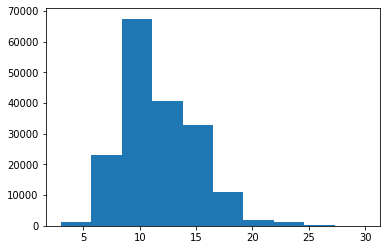

In [177]:
plt.hist(train_df["total_lines"]);

In [178]:
np.percentile(train_df["total_lines"], 95)

18.0

In [179]:
train_df_total_lines= train_df["total_lines"].to_numpy()
val_df_total_lines= val_df["total_lines"].to_numpy()
test_df_total_lines= test_df["total_lines"].to_numpy()

train_df_total_lines, train_df_total_lines.shape

(array([11, 11, 11, ..., 11, 11, 11]), (180040,))

In [180]:
train_df_total_lines.dtype

dtype('int64')

### One-Hot Encoding the `Total Lines` of the datasets

In [181]:
train_total_lines_one_hot= tf.one_hot(train_df_total_lines, depth=18)
val_total_lines_one_hot= tf.one_hot(val_df_total_lines, depth=18)
test_total_lines_one_hot= tf.one_hot(test_df_total_lines, depth=18)

train_total_lines_one_hot, train_total_lines_one_hot.shape

(<tf.Tensor: shape=(180040, 18), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 18]))

In [182]:
train_total_lines_one_hot.dtype

tf.float32

## `Model: 5` Building a tribrid embedding model

### Steps: 

1. Create a token-level model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification to reflect the paper)
3. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
4. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
5. Combine (using layers.Concatenate) the `outputs of 1 and 2` into a   `token-character-hybrid embedding` and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
6. Combine (using layers.Concatenate) the `outputs of 3, 4 and 5` into a `token-character-positional tribrid embedding`
7. Create an `output layer` to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model


### `1` Token Level Inputs

In [183]:
token_inputs= layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings= tf_hub_embedding_layer(token_inputs)
token_outputs= layers.Dense(128, activation="relu")(token_embeddings)
token_model= tf.keras.Model(token_inputs, token_outputs)

### `2` Character Level Inputs

In [184]:
character_inputs= layers.Input(shape= (1,), dtype="string", name="character_inputs")
character_vectors= char_vectorizer(character_inputs)
character_embeddings= char_embedding(character_vectors)
character_bi_lstm= layers.Bidirectional(layers.LSTM(24))(character_embeddings)
character_model= tf.keras.Model(character_inputs, character_bi_lstm)

### `3` Line Number Model

In [185]:
line_number_inputs= layers.Input(shape= (15,), dtype=tf.float32, name="line_number_inputs")

dense_layer= layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model= tf.keras.Model(line_number_inputs, dense_layer)

### `4` Total Lines Model

In [186]:
total_lines_inputs= layers.Input(shape=(18,), dtype=tf.float32, name="total_lines_inputs")
dense_layer= layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model= tf.keras.Model(total_lines_inputs, dense_layer)

### `5` Combine Token and Character Embedding

In [187]:
combined_embeddings= layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, character_model.output])

dense_layer= layers.Dense(256, activation="relu")(combined_embeddings)
x= layers.Dropout(0.5)(dense_layer)

### `6` Combine the positional embeddings with combined token and character embeddings

In [188]:
tribrid_embeddings= layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output, total_lines_model.output, x])

### `7` Create Output Layer

In [189]:
output_layer= layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

### `8` Putting all the model together

In [190]:
model_5= tf.keras.Model(inputs=[line_number_model.inputs, total_lines_model.inputs, token_model.inputs, character_model.inputs,], outputs=output_layer, name="tribrid_embedding_model_5")

In [191]:
model_5.summary()

Model: "tribrid_embedding_model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 character_inputs (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['character_inputs[0][0]']       
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_i

### Visualize the model

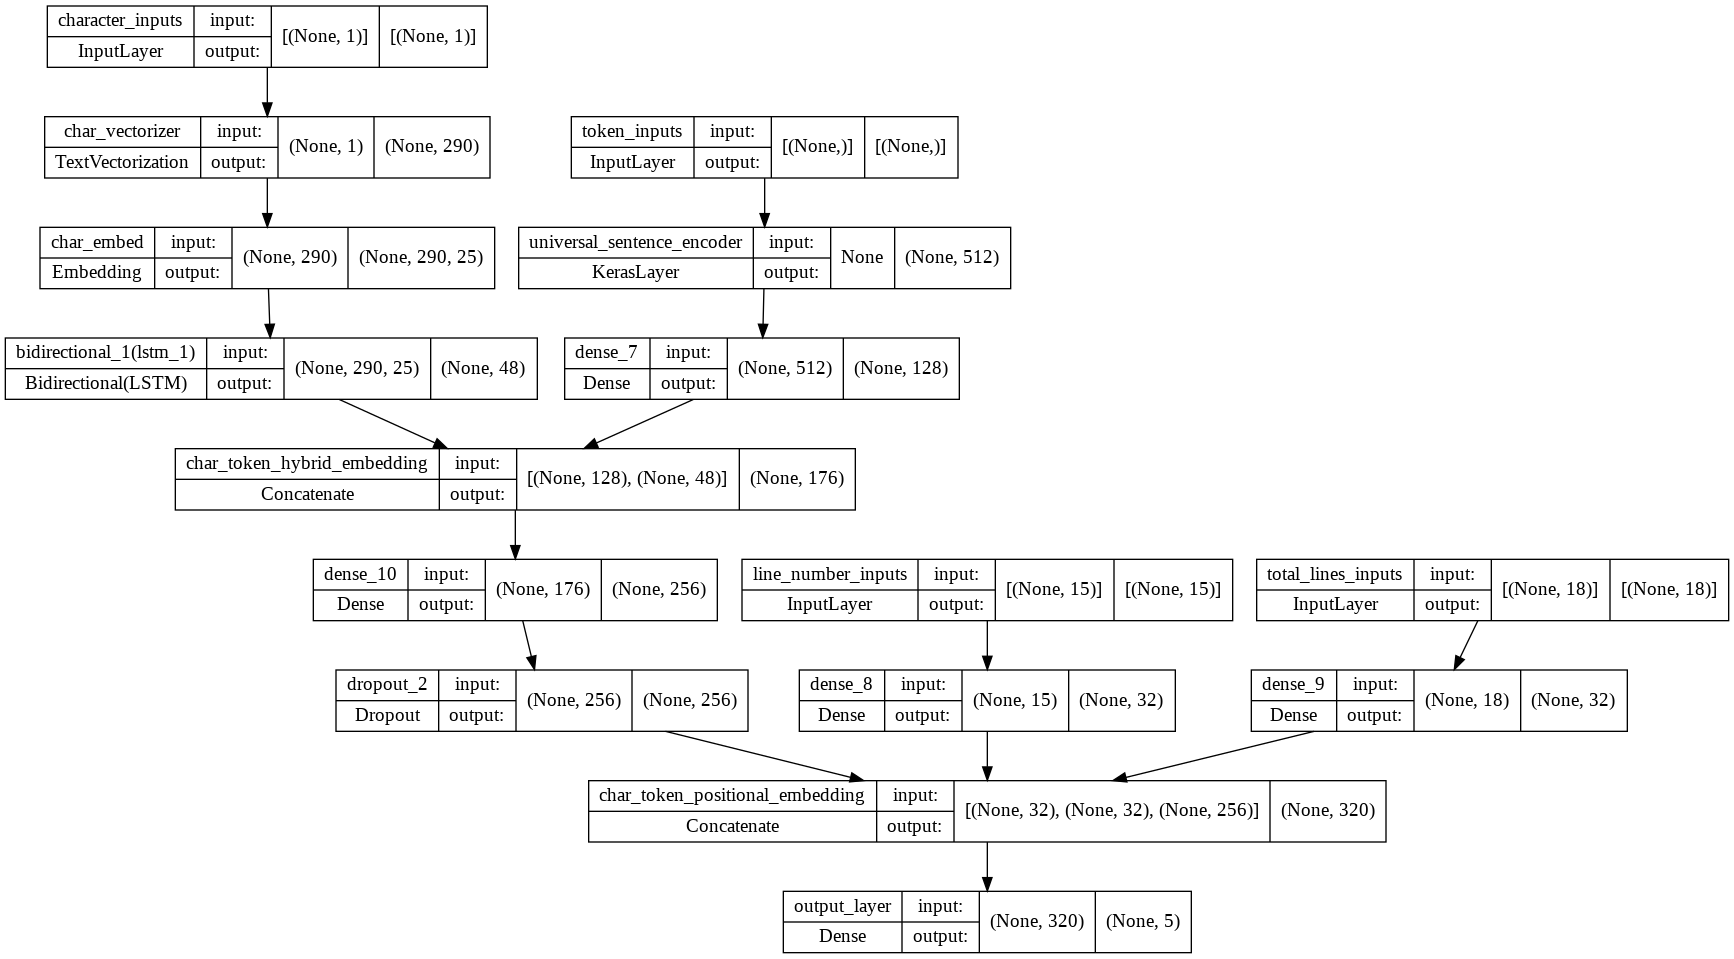

In [192]:
plot_model(model_5, show_shapes=True)

## Label Smoothing

> Helps to `prevent overfitting`. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

### For example, instead of having an output prediction of:

`[0.0, 0.0, 1.0, 0.0, 0.0]` for a sample (the model is very confident the right label is index 2).

> It's predictions will get smoothed to be something like:

`[0.01, 0.01, 0.096, 0.01, 0.01]` giving a small activation to each of the other labels, in turn, hopefully improving generalization.


In [193]:
model_5.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])

## Making datasets load/performance better

In [194]:
train_line_total_token_char_data= tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_characters)) # Data
train_line_total_token_char_labels= tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # Labels
train_line_total_token_char_dataset= tf.data.Dataset.zip((train_line_total_token_char_data, train_line_total_token_char_labels)) # Combining data and labels

train_line_total_token_char_dataset= train_line_total_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_line_total_token_char_data= tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences, val_characters))
val_line_total_token_char_labels= tf.data.Dataset.from_tensor_slices(val_labels_one_hot) 
val_line_total_token_char_dataset= tf.data.Dataset.zip((val_line_total_token_char_data, val_line_total_token_char_labels)) 

val_line_total_token_char_dataset= val_line_total_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


test_line_total_token_char_data= tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, test_total_lines_one_hot, test_sentences, test_characters))
test_line_total_token_char_labels= tf.data.Dataset.from_tensor_slices(test_labels_one_hot) 
test_line_total_token_char_dataset= tf.data.Dataset.zip((test_line_total_token_char_data, test_line_total_token_char_labels)) 

test_line_total_token_char_dataset= test_line_total_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



train_line_total_token_char_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [195]:
history_5= model_5.fit(train_line_total_token_char_dataset, epochs=5, steps_per_epoch=int(0.1 * len(train_line_total_token_char_dataset)), validation_data=val_line_total_token_char_dataset, validation_steps=int(0.1 * len(val_line_total_token_char_dataset)), callbacks=[create_tensorboard_callback(SAVE_DIR, "model_5_tribrid_embedding_model")])

Saving TensorBoard log files to: model_logs/model_5_tribrid_embedding_model/20220828-072322
Epoch 1/5
562/562 [==============================] - 40s 56ms/step - loss: 1.0928 - accuracy: 0.7280 - val_loss: 0.9763 - val_accuracy: 0.8128
Epoch 2/5
562/562 [==============================] - 30s 53ms/step - loss: 0.9638 - accuracy: 0.8184 - val_loss: 0.9464 - val_accuracy: 0.8328
Epoch 3/5
562/562 [==============================] - 26s 47ms/step - loss: 0.9481 - accuracy: 0.8262 - val_loss: 0.9382 - val_accuracy: 0.8295
Epoch 4/5
562/562 [==============================] - 30s 54ms/step - loss: 0.9369 - accuracy: 0.8360 - val_loss: 0.9284 - val_accuracy: 0.8378
Epoch 5/5
562/562 [==============================] - 28s 50ms/step - loss: 0.9347 - accuracy: 0.8387 - val_loss: 0.9242 - val_accuracy: 0.8428


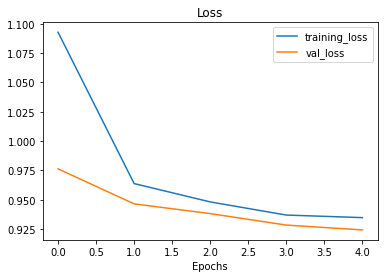

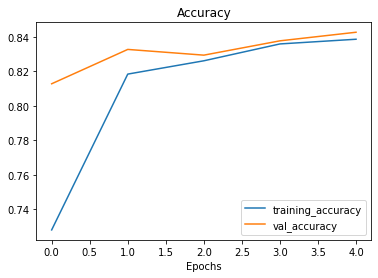

In [196]:
plot_loss_curves(history_5)

In [197]:
model_5_evaluate=model_5.evaluate(val_line_total_token_char_dataset)
model_5_evaluate

945/945 [==============================] - 23s 24ms/step - loss: 0.9215 - accuracy: 0.8438


[0.9215428233146667, 0.8438037633895874]

In [198]:
model_5_pred_probs= model_5.predict(val_line_total_token_char_dataset)
model_5_pred_probs

array([[0.6000818 , 0.07672922, 0.01408896, 0.28752702, 0.02157304],
       [0.6204931 , 0.07789224, 0.08430976, 0.20329648, 0.01400828],
       [0.37894502, 0.10268892, 0.15736316, 0.32082254, 0.04018036],
       ...,
       [0.02933107, 0.05478666, 0.03384556, 0.02522174, 0.85681504],
       [0.02488349, 0.35211027, 0.11542904, 0.02190076, 0.48567638],
       [0.08903325, 0.67507595, 0.11751292, 0.02489379, 0.09348407]],
      dtype=float32)

In [199]:
model_5_preds= tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [200]:
model_5_results= calculate_results(val_labels_encoder, model_5_preds)
model_5_results

{'accuracy': 84.38037865748709,
 'precision': 0.8481133676746472,
 'recall': 0.8438037865748709,
 'f1': 0.8395251027687191}

In [201]:
model_4_results

{'accuracy': 74.62928637627432,
 'precision': 0.745298880216739,
 'recall': 0.7462928637627433,
 'f1': 0.7396995279441884}

In [202]:
model_3_results

{'accuracy': 49.516748311929035,
 'precision': 0.4663114765918066,
 'recall': 0.4951674831192904,
 'f1': 0.4586469706900689}

In [203]:
model_3_1_results

{'accuracy': 66.27499007017079,
 'precision': 0.6794439370228661,
 'recall': 0.6627499007017079,
 'f1': 0.6690440483559759}

In [204]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Comparing the Model's Results

In [205]:
all_model_results= pd.DataFrame({
    "model_0_baseline": baseline_results,
    "model_1_custom_token_embeddings": model_1_results,
    "model_2_USE_feature_extractor": model_2_results,
    "model_3_custom_character_embeddings": model_3_results,
    "model_3_1_custom_character_embeddings": model_3_1_results,
    "model_4_hybrid_token_and_character_embeddings": model_4_results,
    "model_5_tribrid_token_character_and_positional_embeddings": model_5_results

})

all_model_results= all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embeddings,80.153581,0.800332,0.801536,0.799685
model_2_USE_feature_extractor,68.780617,0.679210,0.687806,0.678472
model_3_custom_character_embeddings,49.516748,0.466311,0.495167,0.458647
model_3_1_custom_character_embeddings,66.274990,0.679444,0.662750,0.669044
model_4_hybrid_token_and_character_embeddings,74.629286,0.745299,0.746293,0.739700
model_5_tribrid_token_character_and_positional_embeddings,84.380379,0.848113,0.843804,0.839525


In [206]:
all_model_results["accuracy"]= all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embeddings,0.801536,0.800332,0.801536,0.799685
model_2_USE_feature_extractor,0.687806,0.679210,0.687806,0.678472
model_3_custom_character_embeddings,0.495167,0.466311,0.495167,0.458647
model_3_1_custom_character_embeddings,0.662750,0.679444,0.662750,0.669044
model_4_hybrid_token_and_character_embeddings,0.746293,0.745299,0.746293,0.739700
model_5_tribrid_token_character_and_positional_embeddings,0.843804,0.848113,0.843804,0.839525


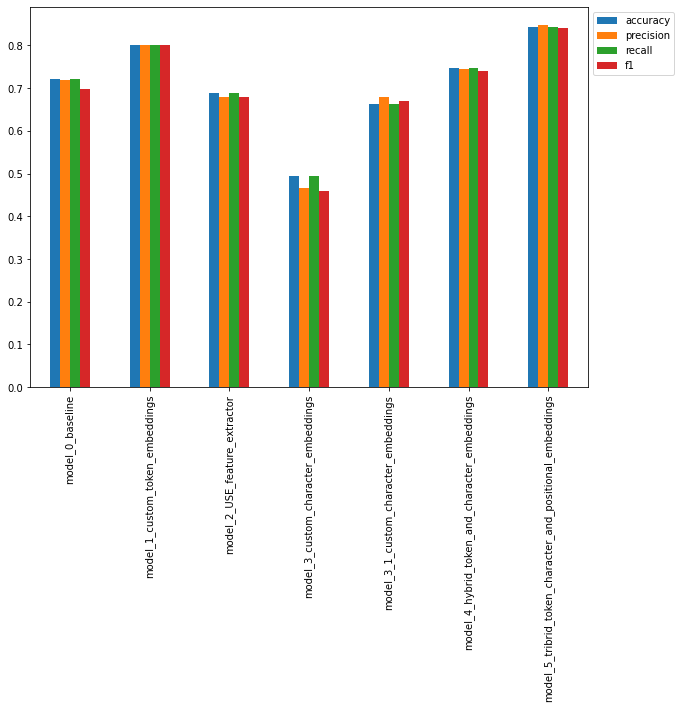

In [207]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

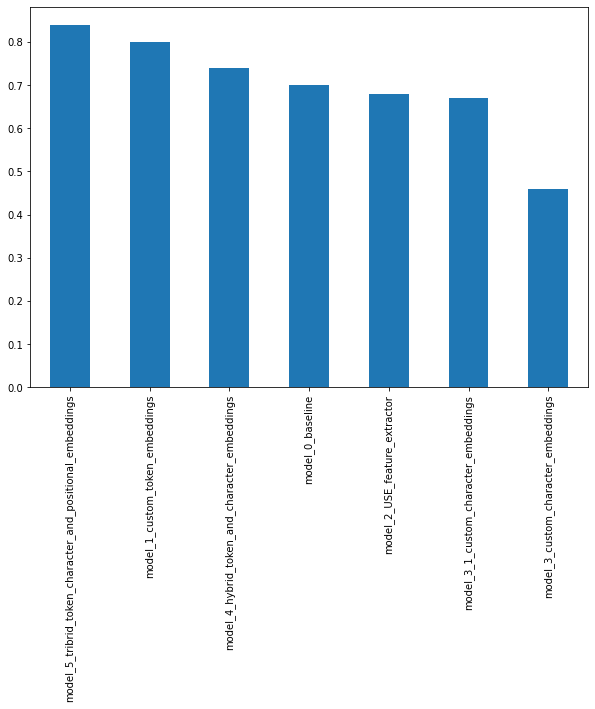

In [208]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

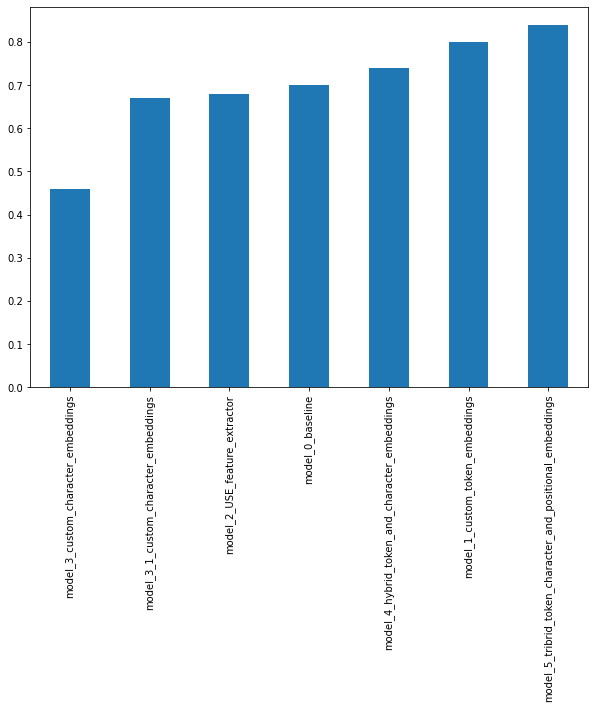

In [209]:
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7));

## Save and Load Model

In [210]:
SAVE_MODEL='models'

In [211]:
model_5.save(SAVE_MODEL)

In [212]:
loaded_model= tf.keras.models.load_model(SAVE_MODEL)
loaded_model

In [213]:
loaded_model_evaluate=loaded_model.evaluate(val_line_total_token_char_dataset)
loaded_model_evaluate

945/945 [==============================] - 25s 24ms/step - loss: 0.9215 - accuracy: 0.8438


[0.9215428233146667, 0.8438037633895874]

In [214]:
model_5_evaluate

[0.9215428233146667, 0.8438037633895874]

In [215]:
loaded_model_evaluate == model_5_evaluate

True

In [216]:
loaded_model_pred_probs= loaded_model.predict(val_line_total_token_char_dataset)
loaded_model_pred_probs

array([[0.6000817 , 0.07672926, 0.01408896, 0.28752702, 0.02157303],
       [0.6204931 , 0.07789227, 0.08430973, 0.2032965 , 0.01400828],
       [0.37894493, 0.10268893, 0.15736319, 0.3208225 , 0.04018035],
       ...,
       [0.02933106, 0.05478668, 0.03384558, 0.02522174, 0.8568149 ],
       [0.0248835 , 0.3521104 , 0.11542907, 0.02190077, 0.48567626],
       [0.08903325, 0.67507595, 0.11751292, 0.02489379, 0.09348407]],
      dtype=float32)

In [217]:
loaded_model_preds= tf.argmax(loaded_model_pred_probs, axis=1)
loaded_model_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [218]:
loaded_model_results= calculate_results(val_labels_encoder, loaded_model_preds)
loaded_model_results

{'accuracy': 84.38037865748709,
 'precision': 0.8481133676746472,
 'recall': 0.8438037865748709,
 'f1': 0.8395251027687191}

In [219]:
model_5_results

{'accuracy': 84.38037865748709,
 'precision': 0.8481133676746472,
 'recall': 0.8438037865748709,
 'f1': 0.8395251027687191}

In [220]:
model_5_results == loaded_model_results

True

In [221]:
loaded_model.summary()

Model: "tribrid_embedding_model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 character_inputs (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['character_inputs[0][0]']       
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_i

## Exercise

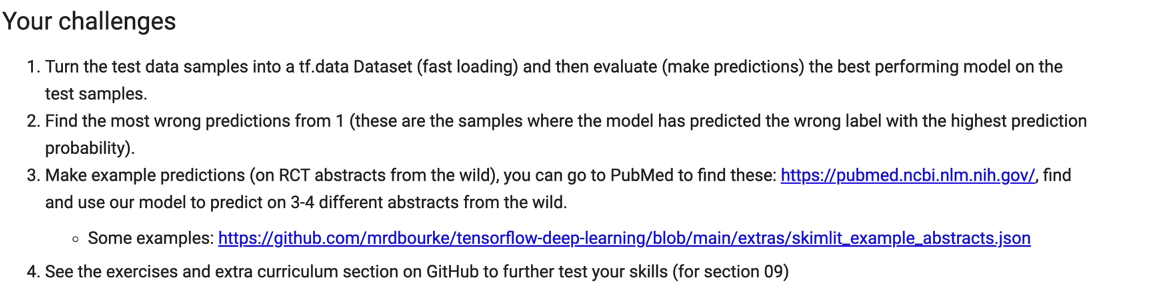

## `1` Already Turned the Test dataset into a prefetched dataset for as fast loading as possible

In [222]:
test_line_total_token_char_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [223]:
val_line_total_token_char_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [224]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [225]:
test_sentences[:5]

['this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
 "the percentage of patients with abnormal lfts decreased significantly from baseline to @-months ' follow-up ."]

In [226]:
val_labels_encoder

array([0, 0, 3, ..., 4, 1, 1])

In [227]:
test_labels_encoder

array([0, 4, 4, ..., 4, 4, 1])

### Making Prediction on the `Test Dataset` with the loaded model 

In [228]:
loaded_model_pred_probs= loaded_model.predict(test_line_total_token_char_dataset)
loaded_model_preds= tf.argmax(loaded_model_pred_probs, axis=1)
loaded_model_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [229]:
loaded_model_pred_probs

array([[0.32844666, 0.07897671, 0.10393512, 0.41401464, 0.07462691],
       [0.28519037, 0.03994546, 0.3993977 , 0.2357015 , 0.03976498],
       [0.04224608, 0.0204114 , 0.8599186 , 0.05867707, 0.01874689],
       ...,
       [0.06569798, 0.10661596, 0.05356404, 0.04987636, 0.7242456 ],
       [0.07796799, 0.10533304, 0.098431  , 0.05252706, 0.6657409 ],
       [0.07948314, 0.42860734, 0.2540818 , 0.04541578, 0.19241196]],
      dtype=float32)

In [230]:
loaded_model_pred_probs.max(axis=1)

array([0.41401464, 0.3993977 , 0.8599186 , ..., 0.7242456 , 0.6657409 ,
       0.42860734], dtype=float32)

In [231]:
loaded_model_pred_probs.shape

(30135, 5)

In [232]:
tf.squeeze(tf.round(loaded_model_pred_probs))

<tf.Tensor: shape=(30135, 5), dtype=float32, numpy=
array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

In [233]:
tf.argmax(loaded_model_pred_probs, axis=1)

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [237]:
loaded_model_pred_probs.max(axis=1)

array([0.41401464, 0.3993977 , 0.8599186 , ..., 0.7242456 , 0.6657409 ,
       0.42860734], dtype=float32)

In [234]:
loaded_model_results_test_dataset= calculate_results(test_labels_encoder, loaded_model_preds)
loaded_model_results_test_dataset

{'accuracy': 83.67678778828605,
 'precision': 0.8401152970109075,
 'recall': 0.8367678778828604,
 'f1': 0.8324200213305498}

In [235]:
loaded_model_results

{'accuracy': 84.38037865748709,
 'precision': 0.8481133676746472,
 'recall': 0.8438037865748709,
 'f1': 0.8395251027687191}

## `2` Checking out the most wrong predictions

### Get list of class names of test predictions

In [248]:
test_pred_classes = [label_encoder.classes_[pred] for pred in loaded_model_preds]
test_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'METHODS',
 

In [250]:
len(test_pred_classes)

30135

In [251]:
loaded_model_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [255]:
tf.reduce_max(loaded_model_pred_probs, axis=1)

<tf.Tensor: shape=(30135,), dtype=float32, numpy=
array([0.41401464, 0.3993977 , 0.8599186 , ..., 0.7242456 , 0.6657409 ,
       0.42860734], dtype=float32)>

In [256]:
tf.reduce_max(loaded_model_pred_probs, axis=1).numpy()

array([0.41401464, 0.3993977 , 0.8599186 , ..., 0.7242456 , 0.6657409 ,
       0.42860734], dtype=float32)

In [257]:
loaded_model_pred_probs.max(axis=1)

array([0.41401464, 0.3993977 , 0.8599186 , ..., 0.7242456 , 0.6657409 ,
       0.42860734], dtype=float32)

In [258]:
tf.reduce_max(loaded_model_pred_probs, axis=1).numpy() == loaded_model_pred_probs.max(axis=1)

array([ True,  True,  True, ...,  True,  True,  True])

In [259]:
np.allclose(tf.reduce_max(loaded_model_pred_probs, axis=1).numpy(),loaded_model_pred_probs.max(axis=1))

True

### DataFrame for the Test Dataset


* A "prediction" (string) column containing our model's prediction for a given sample.
* A "pred_prob" (float) column containing the model's maximum prediction probabiliy for a given sample.
* A "correct" (bool) column to indicate whether or not the model's prediction matches the sample's target label.


In [261]:
test_df["prediction"]= test_pred_classes
test_df["pred_prob"]= tf.reduce_max(loaded_model_pred_probs, axis=1).numpy()
test_df["correct"]= test_df["prediction"] == test_df["target"]
test_df.head()

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.414015,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.399398,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.859919,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.854835,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.593138,True


## Most Wrong Predictions

In [264]:
most_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)
most_wrong[:10] 

,target,text,line_number,total_lines,prediction,pred_prob,correct
18720,RESULTS,non-diffuse-trickling '' ) .,8,15,BACKGROUND,0.962635,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.953666,False
6027,RESULTS,patients were randomized in a bayesian respons...,4,15,METHODS,0.937359,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.936100,False
14108,CONCLUSIONS,unique identifier : nct@ .,15,15,BACKGROUND,0.927887,False
22375,RESULTS,patients were randomly assigned to receive eit...,4,12,METHODS,0.922662,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.921927,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.921841,False
16840,RESULTS,the primary endpoint was a composite of cardio...,3,12,METHODS,0.917755,False
20040,CONCLUSIONS,chictr.org .,11,12,BACKGROUND,0.916273,False


In [265]:
most_wrong.tail()

,target,text,line_number,total_lines,prediction,pred_prob,correct
3523,METHODS,our laboratory delivers a genome report to phy...,6,13,CONCLUSIONS,0.250738,False
7066,RESULTS,generalized linear models indicated seeking sa...,2,5,CONCLUSIONS,0.246516,False
20776,OBJECTIVE,a telephone-based maintenance intervention imp...,1,7,METHODS,0.245887,False
19049,RESULTS,the neuroimaging data indicated that long-term...,4,10,BACKGROUND,0.245468,False
23023,BACKGROUND,"our aims are to understand how , why , and for...",7,13,CONCLUSIONS,0.235003,False


In [266]:
len(most_wrong)

4919

### Visualizing the Wrong Predictions

In [270]:
for row in most_wrong[:10].itertuples():
  _, target, text, _, _, prediction, pred_prob, correct= row
  print(f"Target: {target}, Correct: {correct}, Pred: {prediction}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: RESULTS, Correct: False, Pred: BACKGROUND, Prob: 0.9626351594924927
Text:
non-diffuse-trickling '' ) .

----

Target: CONCLUSIONS, Correct: False, Pred: METHODS, Prob: 0.9536658525466919
Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

----

Target: RESULTS, Correct: False, Pred: METHODS, Prob: 0.9373592734336853
Text:
patients were randomized in a bayesian response-adaptive design to receive intravenous decitabine @ mg/m ( @ ) daily for @ days or decitabine plus oral valproic acid @ mg/kg daily for @ days .

----

Target: RESULTS, Correct: False, Pred: METHODS, Prob: 0.9361000657081604
Text:
a cluster randomised trial was implemented with @,@ children in @ government primary schools on the south coast of kenya in @-@ .

----

Target: CONCLUSIONS, Correct: False, Pred: BACKGROUND, Prob: 0.9278872013092041
Text:
unique identifier : nct@ .

----

Target: RESULTS, Correct: False, Pred: METHODS, Prob: 0.9226621389389038
Text:
patients were randoml

## `3` Prediction on Custom/unknown RCT sentences

### Download and open example abstracts (copy and pasted from PubMed)

In [273]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

import json
with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

--2022-08-28 08:14:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.2’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-08-28 08:14:59 (62.8 MB/s) - ‘skimlit_example_abstracts.json.2’ saved [6737/6737]



In [275]:
example_abstracts[:5]

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [288]:
example_abstracts[0]['abstract']

'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.'

In [276]:
len(example_abstracts)

4

In [277]:
custom_abstracts= pd.DataFrame(example_abstracts)
custom_abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


### Using `spacy` to split the sentences

> Another option would be to leverage spaCy's (a very powerful NLP library) sentencizer class. Which is an easy to use sentence splitter based on spaCy's English language model.

* Doc Link ->  https://spacy.io/usage/linguistic-features#sbd 

In [285]:
# # Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
# from spacy.lang.en import English
# nlp = English() # setup English sentence parser
# sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
# nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser
# doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
# abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
# abstract_lines


ValueError: ignored

In [338]:
from spacy.lang.en import English
nlp= English()
nlp.add_pipe("sentencizer")
doc= nlp(example_abstracts[0]["abstract"])
abstract_lines= [str(sent) for sent in list(doc.sents)]
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [326]:
# import spacy

# nlp = spacy.load("en_core_web_sm")
# doc = nlp(example_abstracts[0]["abstract"])
# for sent in list(doc.sents):
#     abstract_lines= str(sent)

# abstract_lines

'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.'

In [339]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [340]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [341]:
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=18)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 18), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]], dtype=float32)>

In [342]:
# Split abstract lines into characters
abstract_chars = [split_sentences(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [343]:
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [344]:
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 18), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]], dtype=float32)>

In [345]:
tf.constant(abstract_lines)

<tf.Tensor: shape=(8,), dtype=string, numpy=
array([b'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
       b'Participants were randomly assigned to treatment or wait-list conditions.',
       b'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
       b'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
       b'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
       b'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
       b'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
       b'Standardized effect size estimates were primarily in the medium and large ranges and fav

In [346]:
tf.constant(abstract_chars)

<tf.Tensor: shape=(8,), dtype=string, numpy=
array([b'T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
       b'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
       b'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
       b'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
       b'S i g n i f i c a n t   t r e a t m e n 

In [347]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

CPU times: user 3.06 s, sys: 63.1 ms, total: 3.12 s
Wall time: 3.11 s


array([[0.38822007, 0.10547333, 0.02792244, 0.43180355, 0.04658056],
       [0.0657161 , 0.02702732, 0.7682081 , 0.07896393, 0.06008462],
       [0.10217038, 0.03942163, 0.7066186 , 0.09474815, 0.05704119],
       [0.07962535, 0.1061098 , 0.6387479 , 0.0550095 , 0.12050749],
       [0.04550995, 0.0829221 , 0.5554856 , 0.0397739 , 0.27630845],
       [0.0349651 , 0.08942159, 0.6592593 , 0.03907891, 0.17727505],
       [0.02721924, 0.18868975, 0.13474695, 0.02293352, 0.62641054],
       [0.01663232, 0.10841194, 0.22593124, 0.02997691, 0.61904764]],
      dtype=float32)

In [348]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [349]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [350]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
